In [90]:
import numpy as np
from sqlalchemy import create_engine, inspect
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sn
from urllib.parse import quote_plus
import copy
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency, pointbiserialr, probplot, shapiro, anderson
from scipy.stats import linregress, ttest_ind
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mutual_info_score


In [2]:
packages = ['numpy', 'sqlalchemy', 'pandas', 'matplotlib', 'seaborn', 'scipy', 'sklearn']

# Import each package dynamically and print its version
for package in packages:
    pkg = __import__(package)
    print(f"{package} version: {pkg.__version__}")

numpy version: 1.24.2
sqlalchemy version: 2.0.31
pandas version: 2.2.0
matplotlib version: 3.7.0
seaborn version: 0.12.2
scipy version: 1.10.1
sklearn version: 1.5.0


In [2]:
# In Many Cases, Describe Is Not Readable Enough To Be Used
# This Function Make Some Changes To beautify The Describe Function

def beautify_desc(df: pd.DataFrame, columns: list):
    # Select Only The Desired Columns From The DataFrame
    selected_df = df[columns]
    desc_df = selected_df.describe()
    
    # Ensure The DataFrame Can Handle String Assignments By Converting The Entire DataFrame To Object dtype
    desc_df = desc_df.astype(object)
    
    # Format The 'count' Row As Integers 
    desc_df.loc['count'] = desc_df.loc['count'].astype(int).apply(lambda x: f"{x:,}")
    
    # Format Other Statistics With Two Decimal Places And Commas
    desc_df = desc_df.map(lambda x: f"{x:,.3f}" if isinstance(x, (int, float)) else x)
    
    return desc_df


In [3]:
def categorical_numeric_correlations(df, cat_cols, num_col):
    results = {}
    
    for cat_col in cat_cols:
        # Chi-squared test (with binning)
        # Since The UnitPrice Is Numerical, It Should Convert To Categorical Values
        # Here Bins Has Been Used
        bins = pd.cut(df[num_col], bins=5)
        contingency_table = pd.crosstab(df[cat_col], bins)
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        

        
        # Mutual Information
        """
        mutual_info_regression calculates the mutual information between a continuous target variable
        (in this case, our 'UnitPrice') and one or more other variables.
        Mutual Information (MI) measures the mutual dependence between two variables. 
        In other words, it quantifies the amount of information obtained about one variable by 
        observing the other variable.        
        """
        le = LabelEncoder()
        encoded_cat = le.fit_transform(df[cat_col]).reshape(-1, 1)
        mi = mutual_info_regression(encoded_cat, df[num_col])[0]
        
        results[cat_col] = {
            'chi2': chi2,
            'chi2_p_value': p_value,
            'mutual_information': mi
        }
    
    # Random Forest Feature Importance
    le = LabelEncoder()
    X = df[cat_cols].apply(le.fit_transform)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, df[num_col])
    importances = rf.feature_importances_
    
    for col, importance in zip(cat_cols, importances):
        results[col]['rf_importance'] = importance
    
    return results

In [4]:
def q_q_plot(df, num_cols):
    # Trim column names
    df.columns = df.columns.str.strip()
    num_cols = [col.strip() for col in num_cols]

    number_of_plots = len(num_cols)
    plt.figure(figsize=(8, number_of_plots * 4))  # Adjust the figure size to accommodate all plots

    for i, col in enumerate(num_cols):
        plt.subplot(number_of_plots, 1, i + 1)
        probplot(df[col].dropna(), dist="norm", plot=plt)
        plt.title(f'Q-Q Plot for {col}')
        plt.xlabel('')
        plt.ylabel('')

    plt.tight_layout()
    plt.show()

            

In [5]:
def plot_histograms(df, columns, bins=50, figsize=(15, 6)):
    fig, axes = plt.subplots(1, len(columns), figsize=figsize)
    if len(columns) == 1:
        axes = [axes]
    
    for ax, column in zip(axes, columns):
        data = df[column]
        
        # Plot the histogram
        ax.hist(data, bins=bins, edgecolor='black')
        
        # Set titles and labels
        ax.set_title(f'Histogram of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        
        # Add mean and median lines
        mean = data.mean()
        median = data.median()
        ax.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
        ax.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
        
        ax.legend()
        
        # If the column is 'Bytes', use log scale on x-axis
        if column == 'Bytes':
            ax.set_xscale('log')
            ax.set_xlabel(f'{column} (log scale)')
    
    plt.tight_layout()
    plt.show()

In [6]:
# Looking For Outliers Using Z-Score
# In This Function, Z-Score Greater That 3 And Lower Than -3 Will Be Considered As An Outlier
def z_score_outliers_fun(df, columns, limit):
    outliers = {}
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        z_scores = (df[col] - mean) / std
        outlier =  df[(np.abs(z_scores) > limit)]
        outlier = outlier.dropna()
        outliers[f'{col}'] = outlier['TrackId']
    return outliers



In [7]:
# Function to detect outliers using IQR 
def iqr_outliers_fun(df, columns):
    outliers = {}
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier = df[(df[column] < lower_bound) | (df[column] > upper_bound)]['TrackId'].tolist()
        outliers[f'{column}'] = outlier
        print(f"\nOutliers in {column}:")
        print(f"Number of outliers: {len(outliers[column])}")
        print(f"Percentage of outliers: {len(outliers[column]) / len(df) * 100:.2f}%")
        print(f"Range for non-outliers: {lower_bound:.2f} to {upper_bound:.2f}")
        
    return outliers


In [8]:
# Function to detect outliers using Isolation_Forest
def isolation_forest_outliers(df, columns, contamination=0.01):
    outliers = {}
    for col in columns:
        # Reshape data for Isolation Forest
        X = df[[col]].values
        
        # Initialize and fit Isolation Forest
        clf = IsolationForest(contamination=contamination, random_state=42)
        outlier_labels = clf.fit_predict(X)
        
        # Collect TrackIds of outliers
        outliers[col] = df[outlier_labels == -1]['TrackId'].tolist()
        print(f"\nOutliers in {col}:")
        print(f"Number of outliers: {len(outliers[col])}")
        print(f"Percentage of outliers: {len(outliers[col]) / len(df) * 100:.2f}%")
        
    
    return outliers

In [9]:
def outliers_intersection(outliers1, outliers2):
    inter_out = []
    for i in outliers1:
        for j in outliers2:
            if i==j:
                inter_out.append(i)
            else:
                continue
    print(f'The Number Of Common Outliers Between These Two Lists is: {len(inter_out)} ')

In [10]:
def calculate_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)
    interval = stats.t.interval(confidence, len(data)-1, loc=mean, scale=sem)
    return mean, interval

In [11]:
# Reading The Database Config File 
with open("./DB_Config.json", "r") as file:
    conf = json.load(file) 
db_conf = conf['DataBaseConfig']
host=db_conf['host']
port=db_conf['port']
user=db_conf['user']
password=db_conf['password']
db=db_conf['database']

# In Oder To Make Sure That SQLAlchemy Enginge Does Not Confuse The Password with Host We Use This Line
encoded_password = quote_plus(password)

In [12]:
# Creatin A SQL Alchemy Engine Inorder To Connect To DB
connection_string = f"mysql+pymysql://{user}:{encoded_password}@{host}:{port}/{db}"
engine = create_engine(connection_string)

In [13]:
# Create An Inspector To Fetch Table Names
inspector = inspect(engine)
tables = inspector.get_table_names()

In [14]:
# Create a Loop To Get Actual Tables One by One
for tabel_name in tables:
    query = f"SELECT * FROM {tabel_name}"
    
    # Converting The Tables Into Pandas DataFrame
    df = pd.read_sql(query,engine)
    
    # Creating Global Variables For Each Table 
    var_name = "".join(tabel_name) + "_df"
    globals()[var_name] = df
# Now We Have 11 DataFrame, Which Has Name Based on Tables + _df

Now we are looking into the information of some tables that might be more important to check for null values and other parameters.
If the table contains numerc values, I also use describe method to check for statistical variables.

In [15]:
track_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3503 entries, 0 to 3502
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TrackId       3503 non-null   int64  
 1   Name          3503 non-null   object 
 2   AlbumId       3503 non-null   int64  
 3   MediaTypeId   3503 non-null   int64  
 4   GenreId       3503 non-null   int64  
 5   Composer      2526 non-null   object 
 6   Milliseconds  3503 non-null   int64  
 7   Bytes         3503 non-null   int64  
 8   UnitPrice     3503 non-null   float64
dtypes: float64(1), int64(6), object(2)
memory usage: 246.4+ KB


In [16]:
# Only 'Milliseconds', 'Bytes' and 'UnitPrice' Are Actual Numeric Values 
track_desc_df = beautify_desc(track_df,['Milliseconds','Bytes','UnitPrice'])
track_desc_df

,Milliseconds,Bytes,UnitPrice
count,"3,503","3,503","3,503"
mean,"393,599.212","33,510,207.065",1.051
std,"535,005.435","105,392,533.665",0.239
min,"1,071.000","38,747.000",0.990
25%,"207,281.000","6,342,566.000",0.990
50%,"255,634.000","8,107,896.000",0.990
75%,"321,645.000","10,266,789.500",0.990
max,"5,286,953.000","1,059,546,140.000",1.990


In [17]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerId    59 non-null     int64 
 1   FirstName     59 non-null     object
 2   LastName      59 non-null     object
 3   Company       10 non-null     object
 4   Address       59 non-null     object
 5   City          59 non-null     object
 6   State         30 non-null     object
 7   Country       59 non-null     object
 8   PostalCode    55 non-null     object
 9   Phone         58 non-null     object
 10  Fax           12 non-null     object
 11  Email         59 non-null     object
 12  SupportRepId  59 non-null     int64 
dtypes: int64(2), object(11)
memory usage: 6.1+ KB


There are some null values in this dataset, However the important columns have not any null values.</br>
In many fields of these tables, null values can be interpreted logically.

In [18]:
employee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   EmployeeId  8 non-null      int64         
 1   LastName    8 non-null      object        
 2   FirstName   8 non-null      object        
 3   Title       8 non-null      object        
 4   ReportsTo   7 non-null      float64       
 5   BirthDate   8 non-null      datetime64[ns]
 6   HireDate    8 non-null      datetime64[ns]
 7   Address     8 non-null      object        
 8   City        8 non-null      object        
 9   State       8 non-null      object        
 10  Country     8 non-null      object        
 11  PostalCode  8 non-null      object        
 12  Phone       8 non-null      object        
 13  Fax         8 non-null      object        
 14  Email       8 non-null      object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(11)
memory usage: 1.1+ KB


There is only one null value in this dataframe and it happens in the 'ReportsTo' column. </br>
This likely means that the person who does not report to anyone is the head of the company.

In [19]:
invoice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   InvoiceId          412 non-null    int64         
 1   CustomerId         412 non-null    int64         
 2   InvoiceDate        412 non-null    datetime64[ns]
 3   BillingAddress     412 non-null    object        
 4   BillingCity        412 non-null    object        
 5   BillingState       210 non-null    object        
 6   BillingCountry     412 non-null    object        
 7   BillingPostalCode  384 non-null    object        
 8   Total              412 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 29.1+ KB


There are some null values in two columns 'BillingState' and 'BillingPostalCode'.</br>
Null values in 'BillingState' means customer is not from USA.
Null values in 'BillingPostalCode' could be Problematic.

In [20]:
# The Only Actual Numeric Column Is Total.
describe_df = beautify_desc(invoice_df, ['Total'])
describe_df

,Total
count,412
mean,5.652
std,4.745
min,0.990
25%,1.980
50%,3.960
75%,8.910
max,25.860


In [21]:
invoiceline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   InvoiceLineId  2240 non-null   int64  
 1   InvoiceId      2240 non-null   int64  
 2   TrackId        2240 non-null   int64  
 3   UnitPrice      2240 non-null   float64
 4   Quantity       2240 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 87.6 KB


In [22]:
invoiceline_df_desc = beautify_desc(invoiceline_df,['UnitPrice','Quantity'])
invoiceline_df_desc

,UnitPrice,Quantity
count,"2,240","2,240"
mean,1.040,1.000
std,0.217,0.000
min,0.990,1.000
25%,0.990,1.000
50%,0.990,1.000
75%,0.990,1.000
max,1.990,1.000


The Tables That Have Some Useful Information Are:</br>
<ul>
    <li>Track Table</li>
    <li>Customer Table</li>
    <li>Invoice Table</li>
    <li>InvoiceLine Table</li>


</ul>
Next We are going to look into them in more detail

# Track DataFrame

In [23]:
# First We Want To Find The Distribution Of Songs Based On their Genres 

# Merging The Genre_df and Track_df
track_genre = pd.merge(track_df, genre_df, how='left', on='GenreId', suffixes=('_track', '_genre'))

# We Only Need 'TrackId' and 'Name_genre'
track_genre = track_genre[['TrackId', 'Name_genre']]

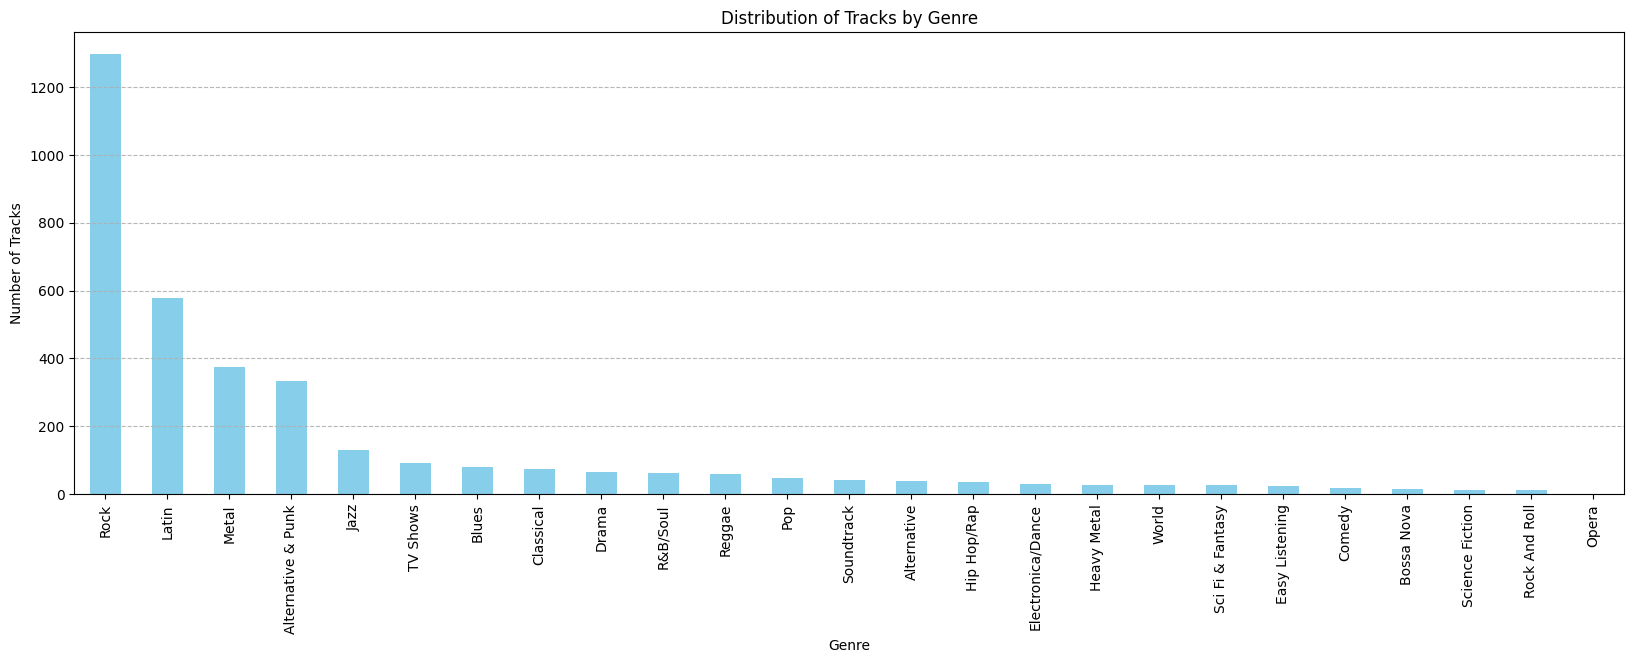

In [24]:
# Counting The Number Of Tracks In Each Genre
count_tracks_by_genre = track_genre['Name_genre'].value_counts()
# Drawing A Bar Chart
plt.figure(figsize=(20, 6))  
count_tracks_by_genre.plot(kind='bar', color='skyblue')  
plt.xlabel('Genre')  
plt.ylabel('Number of Tracks')  
plt.title('Distribution of Tracks by Genre')  # 
plt.xticks(rotation=90)  
plt.grid(axis='y', linestyle='--', alpha=0.9)  
plt.show() 

As we can see in this chart, Top three genres which has the most number of song among all genres are:
<ol>
    <li>Rock</li>
    <li>Latin</li>
    <li>Metal</li>
</ol>

In [25]:
# Now We Find The Distribution Of Songs Based On their MediaType

# Merging The MediaType_df and Track_df
track_media = pd.merge(track_df, mediatype_df, how='left', on='MediaTypeId', suffixes=('_track', '_medi'))

In [26]:
# We Only Need 'TrackId' and 'Name_genre'
track_media = track_media[['TrackId','Name_medi']]
count_tracks_by_media = track_media['Name_medi'].value_counts()
count_tracks_by_media

Name_medi
MPEG audio file                3034
Protected AAC audio file        237
Protected MPEG-4 video file     214
AAC audio file                   11
Purchased AAC audio file          7
Name: count, dtype: int64

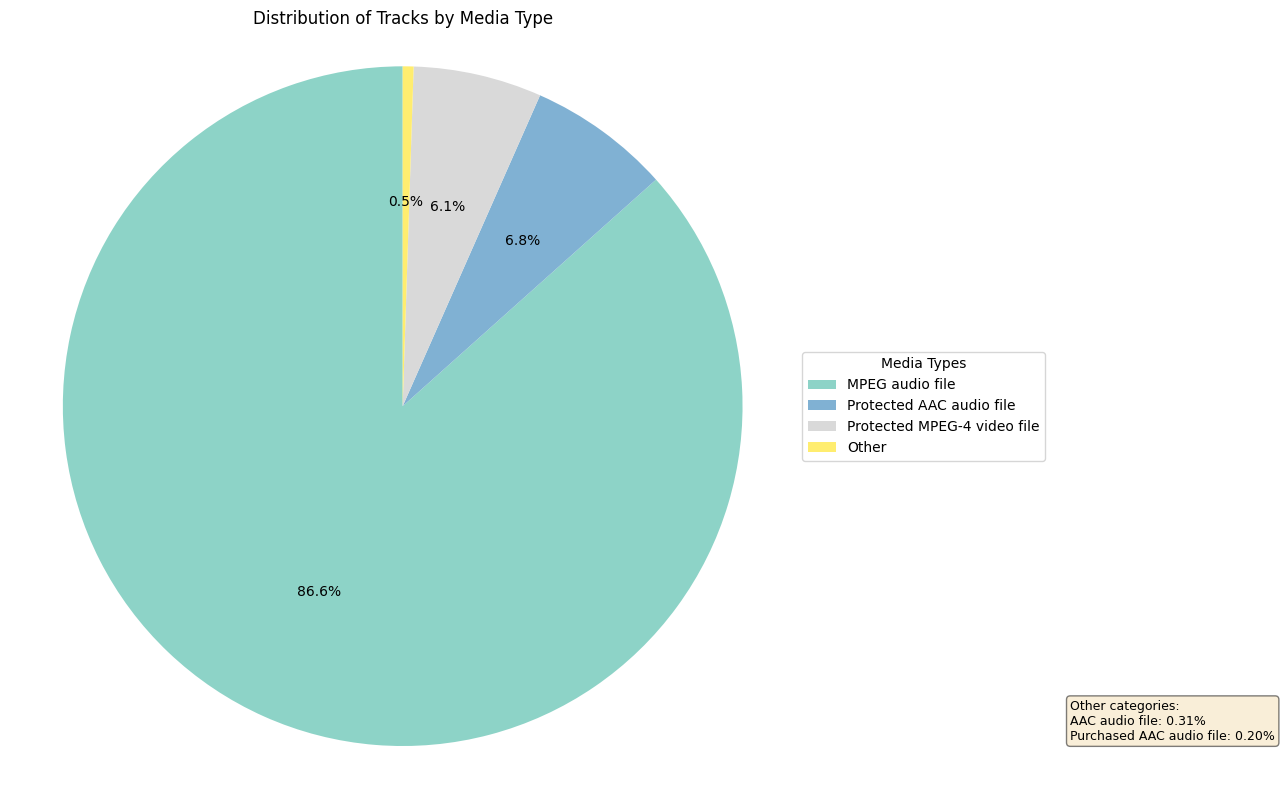

In [27]:
# Since There Are Two MediaType, Which Their Percentage Is Too Small We Combine Them 

sorted_data = count_tracks_by_media.sort_values(ascending=False)

# Determine The Threshold For 'Other' (less than 1%)
threshold = sorted_data.sum() * 0.01
other = sorted_data[sorted_data < threshold]
main_data = sorted_data[sorted_data >= threshold]
main_data['Other'] = other.sum()

# Calculate Percentages For 'Other' Categories
total = sorted_data.sum()
other_percentages = other / total * 100

# Define Colors For Each Slice
colors = plt.cm.Set3(np.linspace(0, 1, len(main_data)))

# Create A Pie Chart
fig, ax = plt.subplots(figsize=(14, 8))
patches, texts, autotexts = ax.pie(main_data.values, colors=colors, autopct='%1.1f%%', startangle=90)
legend = ax.legend(patches, main_data.index, title="Media Types", loc="center left", bbox_to_anchor=(1, 0.5))

# Add a box behind the legend for 'Other' categories
other_text = "Other categories:\n" + "\n".join([f"{index}: {value:.2f}%" for index, value in other_percentages.items()])
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(1.35, 0.05, other_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='bottom', bbox=props)

ax.set_title('Distribution of Tracks by Media Type')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()

As shown in the pie chart, the 'MPEG' media type significantly dominates the industry.

# Customer DataFrame

In [28]:
#First We look At Countries
customers_country = customer_df[['CustomerId','Country']]
count_customers_by_country = customers_country['Country'].value_counts()


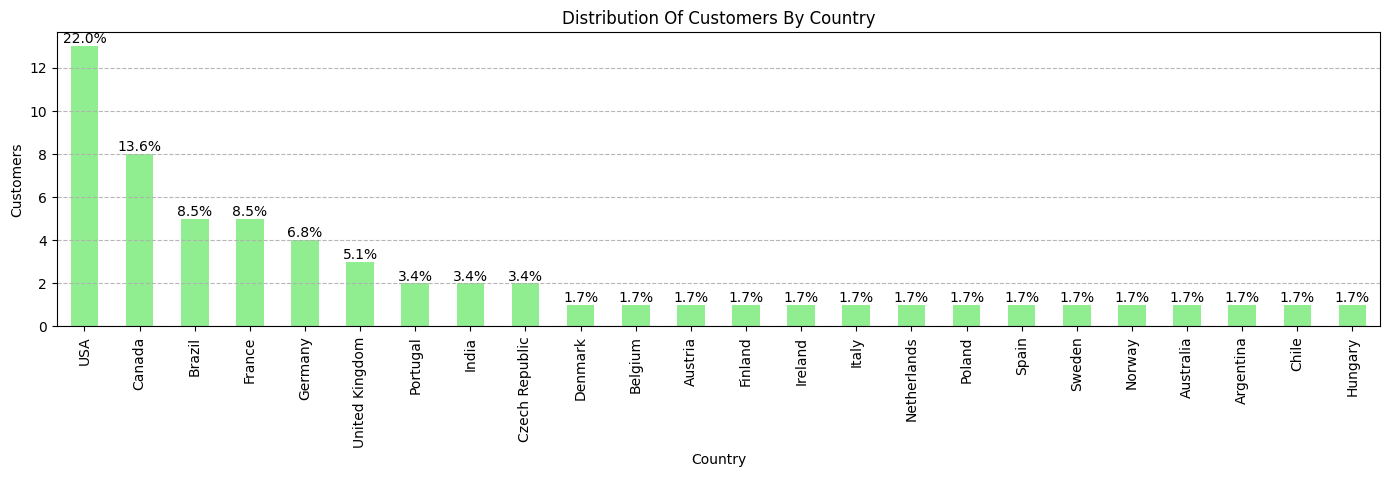

In [30]:
# Calculating The Percentages
total_customers = count_customers_by_country.sum()
percentages = (count_customers_by_country / total_customers) * 100

#Ploting Bar Chart
plt.figure(figsize=(14,5))
ax = count_customers_by_country.plot(kind='bar', color='lightgreen')
plt.xlabel('Country')
plt.ylabel('Customers')
plt.title('Distribution Of Customers By Country')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.9)

# Add percentage labels on top of each bar
for i, v in enumerate(count_customers_by_country):
    ax.text(i, v, f'{percentages.iloc[i]:.1f}%', ha='center', va='bottom')
    
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

The bar chart shows that more than 50% of the company's customers come from four countries:
<ol>
    <li>USA</li>
    <li>Canada</li>
    <li>Brazil</li>
    <li>France</li>
</ol>
More than 35% of company's sales is in North America.

# Invoice DataFrame

In [31]:
new_invoice = copy.deepcopy(invoice_df)
new_invoice['Year'] = new_invoice['InvoiceDate'].dt.year
new_invoice['Month'] = new_invoice['InvoiceDate'].dt.strftime('%b')

In [32]:
grouped = new_invoice.groupby(['Year','Month'])['Total'].sum().reset_index()

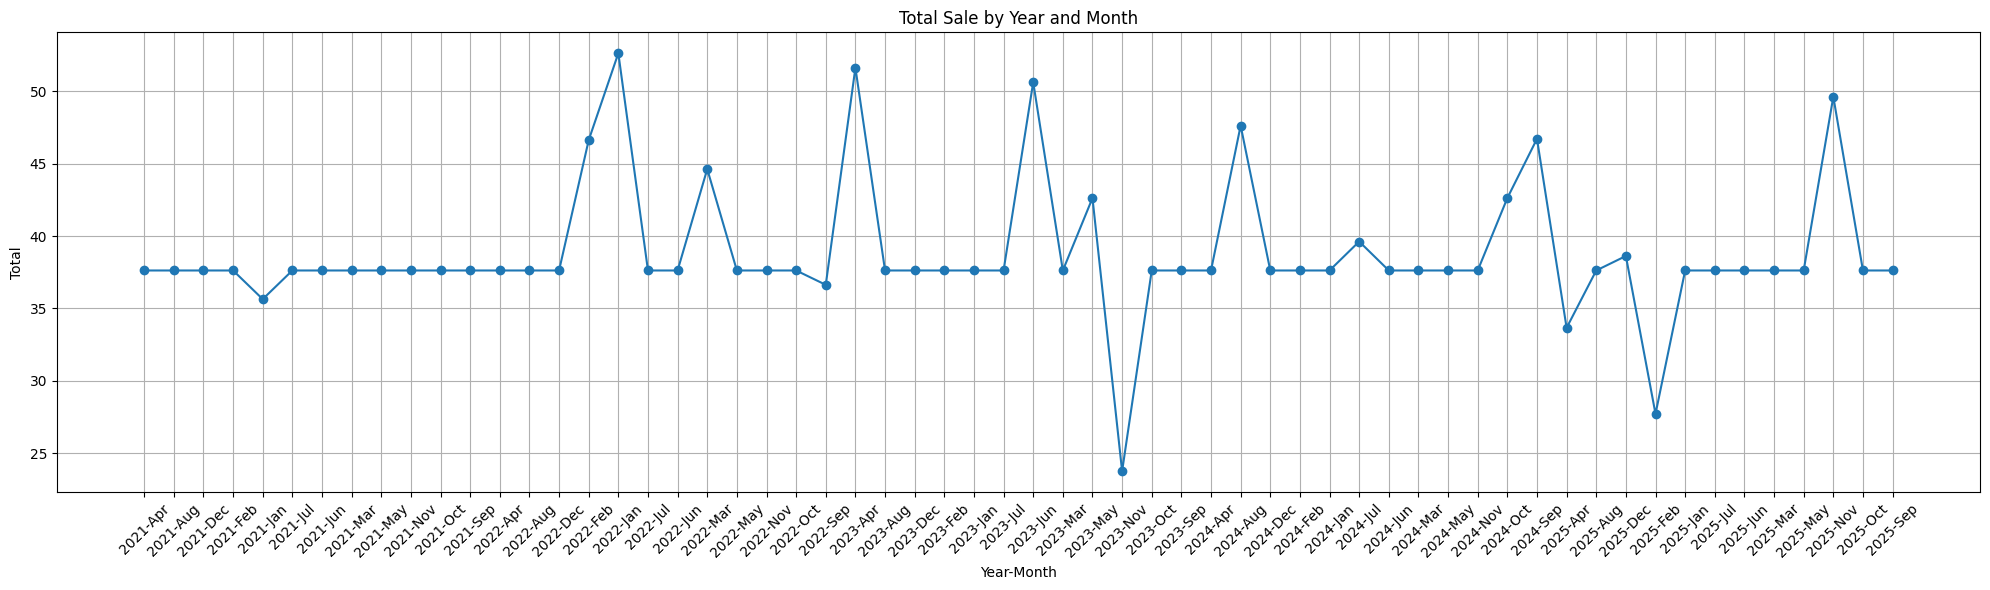

In [33]:
plt.figure(figsize=(20,6))
plt.plot(grouped['Year'].astype(str) + '-' + grouped['Month'].astype(str), grouped['Total'], marker='o')
plt.xlabel('Year-Month')
plt.ylabel('Total')
plt.title('Total Sale by Year and Month')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The Line chart indicates that company's sale in many month throught the years are equal 37.62,
there are some point with sharp increase or decrease which needs more investigation.

In Track Table, I am going to see which feature of a track has more relationship with its price.

In [34]:
#Separating fields which i expect to have some kind of relations with price
track_df_custom = track_df[['TrackId', 'GenreId', 'MediaTypeId', 'Composer', 'UnitPrice']]
# We add genres and MediTypes 
track_df_custom = track_df_custom.merge(genre_df, on='GenreId', how='left')
track_df_custom = track_df_custom.merge(mediatype_df, on='MediaTypeId', how='left')

# Renaming Columns
track_df_custom.rename(columns={'Name_x':'Genre','Name_y':'MediaType'}, inplace= True)

# Dropping GenreId and MediaTypeId
track_df_custom.drop(['MediaTypeId', 'GenreId'], axis=1, inplace=True)

# Reordering Columns
new_order = ['TrackId', 'Genre', 'MediaType', 'Composer', 'UnitPrice']
track_df_custom = track_df_custom.reindex(columns=new_order)

In [35]:
categorical_col = ['Genre', 'MediaType', 'Composer']
numeric_col = 'UnitPrice'  

correlations = categorical_numeric_correlations(track_df_custom, categorical_col, numeric_col)

for col, stats in correlations.items():
    print(f"\n{col}:")
    for metric, value in stats.items():
        print(f"  {metric}: {value:.6f}")


Genre:
  chi2: 3503.000000
  chi2_p_value: 0.000000
  mutual_information: 0.226497
  rf_importance: 0.033682

MediaType:
  chi2: 3485.571075
  chi2_p_value: 0.000000
  mutual_information: 0.218421
  rf_importance: 0.966066

Composer:
  chi2: 0.000000
  chi2_p_value: 1.000000
  mutual_information: 0.072902
  rf_importance: 0.000251


<ol>
    <li>Genre<ul>
        <li>High chi-square value (3503) with a p-value of 0, indicating a significant relationship with price.</li>
<li>Mutual Information of 0.204022, suggesting a moderate level of information shared between Genre and price.</li>
<li>RF importance of 0.033682, indicating some predictive power, but not as strong as MediaType.</li>
        </ul></li><br>
        <li>MediaType<ul>
        <li>High chi-square value (3485.571075) with a p-value of 0, indicating a significant relationship with price.</li>
<li>Highest Mutual Information (0.243092) among the three variables, suggesting it shares the most information with price.</li>
<li>Very high RF importance (0.966066), indicating it's by far the most important feature for predicting price in a Random Forest model.</li>
        </ul></li><br>
        <li>Composer<ul>
        <li>Chi-square value of 0 with a p-value of 1, suggesting no significant relationship with price.</li>
<li>Low Mutual Information (0.079147), indicating little shared information with price.</li>
<li>Very low RF importance (0.000251), suggesting it has almost no predictive power for price in a Random Forest model.</li>
        </ul></li>
</ol>

 We can do the same analysis for tracks based on their total sales.

In [36]:
# Copying The Original DataFrame, So We Don't Change That Unintentionally
inv_line_custome = copy.deepcopy(invoiceline_df)

# First We Need To Calculate The Sales For Each Track In Each Invoice
inv_line_custome['Total_Sale'] = inv_line_custome['Quantity'] * inv_line_custome['UnitPrice']

# Now We Calculate The Sales Of Each Track Among All Invoices
grouped_track_sales = inv_line_custome.groupby('TrackId')['Total_Sale'].sum().reset_index()

# Now We Merge track_df_custom with grouped_track_sales
track_df_custom = track_df_custom.merge(grouped_track_sales, on='TrackId', how='left')

In [37]:
track_df_custom

,TrackId,Genre,MediaType,Composer,UnitPrice,Total_Sale
0,1,Rock,MPEG audio file,"Angus Young, Malcolm Young, Brian Johnson",0.99,0.99
1,2,Rock,Protected AAC audio file,"U. Dirkschneider, W. Hoffmann, H. Frank, P. Ba...",0.99,1.98
2,3,Rock,Protected AAC audio file,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Ho...",0.99,0.99
3,4,Rock,Protected AAC audio file,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. D...",0.99,0.99
4,5,Rock,Protected AAC audio file,Deaffy & R.A. Smith-Diesel,0.99,0.99
...,...,...,...,...,...,...
3498,3499,Classical,Protected AAC audio file,None,0.99,0.99
3499,3500,Classical,Protected AAC audio file,Franz Schubert,0.99,1.98
3500,3501,Classical,Protected AAC audio file,Claudio Monteverdi,0.99,NaN
3501,3502,Classical,Protected AAC audio file,Wolfgang Amadeus Mozart,0.99,NaN


In [38]:
# Sum Values In Total_Sale Are NaN After Megring, Which Means No one purchased that
track_df_custom.fillna({'Total_Sale':0}, inplace=True)

# Calculating The Null Values Again
track_df_custom['Total_Sale'].isnull().sum()

0

In [39]:
categorical_col = ['Genre', 'MediaType', 'Composer']
numeric_col = 'Total_Sale'  

correlations = categorical_numeric_correlations(track_df_custom, categorical_col, numeric_col)

for col, stats in correlations.items():
    print(f"\n{col}:")
    for metric, value in stats.items():
        print(f"  {metric}: {value:.6f}")


Genre:
  chi2: 647.238124
  chi2_p_value: 0.000000
  mutual_information: 0.130307
  rf_importance: 0.174168

MediaType:
  chi2: 517.144826
  chi2_p_value: 0.000000
  mutual_information: 0.116616
  rf_importance: 0.082990

Composer:
  chi2: 1684.633331
  chi2_p_value: 0.626114
  mutual_information: 0.065560
  rf_importance: 0.742842


<ol>
    <li>Genre<ul>
        <li>Moderate chi-squared statistic and very low p-value, indicating a significant relationship with the target variable.</li>
<li>Highest mutual information among the three features, suggesting it provides the most information about the target.</li>
<li>Second highest RF importance, indicating it's valuable for predictions.</li>
        </ul></li><br>
        <li>MediaType<ul>
        <li>Lowest chi-squared statistic, but still with a very low p-value, suggesting a significant but weaker relationship with the target.</li>
<li>Second highest mutual information, close to Genre.</li>
<li>Lowest RF importance, suggesting it's less crucial for predictions in the Random Forest model.</li>
        </ul></li><br>
        <li>Composer<ul>
        <li>Highest chi-squared statistic by far, but also the highest p-value (0.626114), which is not statistically significant at common thresholds. This unusual combination might warrant further investigation.</li>
<li>Lowest mutual information, suggesting it provides the least information about the target among these features.</li>
<li>Highest RF importance by a large margin, indicating it's the most important feature for predictions in the Random Forest model.</li>
        </ul></li>
</ol>

# Normality Test For Numeric Key Features

In [40]:
numeric_features = ['Milliseconds','Bytes']


Q_Q Plot

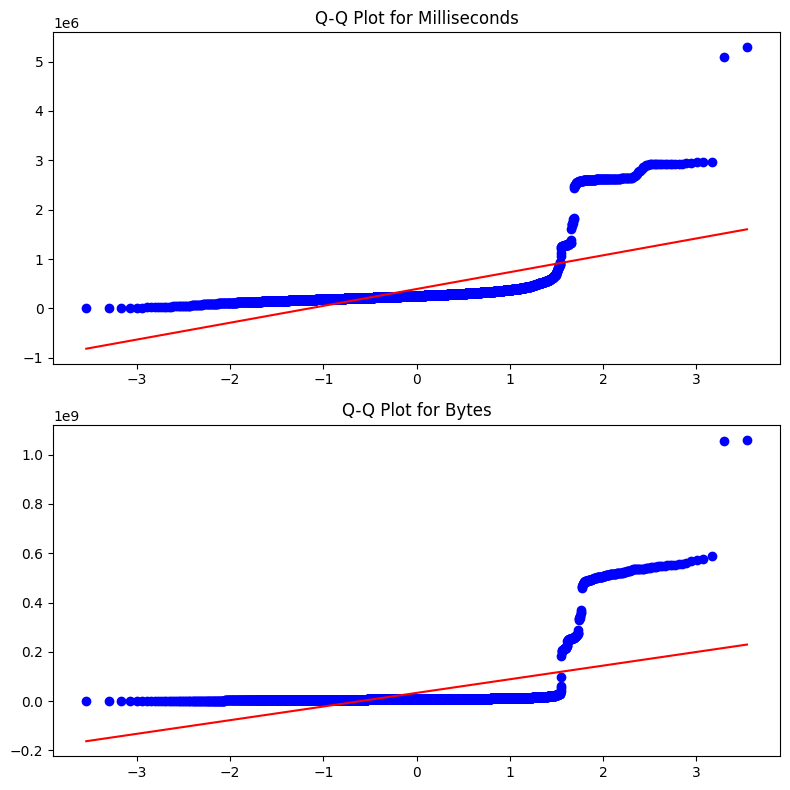

In [41]:
q_q_plot(track_df, numeric_features)

Using QQ-Plot shows 'Milliseconds' and 'Bytes' are not Normal. For more insurance we are looking at different methods.

Shapiro-Wilk Test

In [42]:
for feature in numeric_features:
    stat, p = shapiro(track_df[feature].dropna())
    print(f'Shapiro-Wilk Test for {feature}: Statistics={stat}, p-value={p}')

Shapiro-Wilk Test for Milliseconds: Statistics=0.4069346785545349, p-value=0.0
Shapiro-Wilk Test for Bytes: Statistics=0.27564042806625366, p-value=0.0


The results of the Shapiro-Wilk Test indicate that the columns 'Milliseconds' and 'Bytes' do not follow a normal distribution, as the p-values are both 0.0

Anderson-Darling Test

In [43]:
for feature in numeric_features:
    ad_result = anderson(track_df[feature].dropna(), dist='norm')
    print(f'Statistics for {feature}: {ad_result.statistic}') 
    print(f'Critical Values for {feature}: {ad_result.critical_values}') 
    print(f'Significance Levels for {feature}: {ad_result.significance_level}')

Statistics for Milliseconds: 791.0662880650152
Critical Values for Milliseconds: [0.575 0.655 0.786 0.917 1.091]
Significance Levels for Milliseconds: [15.  10.   5.   2.5  1. ]
Statistics for Bytes: 1115.6309453985177
Critical Values for Bytes: [0.575 0.655 0.786 0.917 1.091]
Significance Levels for Bytes: [15.  10.   5.   2.5  1. ]


<ol>
<li>Milliseconds:</li>
    <ul>
        <li>Test Statistic: 791.066</li>
        <li>Critical Values: [0.575, 0.655, 0.786, 0.917, 1.091]</li>
        <li>Significance Levels: [15%, 10%, 5%, 2.5%, 1%]</li>
        <li>The test statistic (791.066) is much larger than any of the critical values at all significance levels. This means that we reject the null hypothesis that the 'Milliseconds' data comes from a normal distribution.</li>
     </ul>
 

<li>Bytes:</li>
    <ul>
        <li>Test Statistic: 1115.631</li>
        <li>Critical Values: [0.575, 0.655, 0.786, 0.917, 1.091]</li>
        <li>Significance Levels: [15%, 10%, 5%, 2.5%, 1%]</li>
        <li>Similarly, the test statistic (1115.631) is much larger than the critical values at all significance levels. This means we also reject the null hypothesis for the 'Bytes' data.</li>
    </ul>
        
</ol>

# Outliers

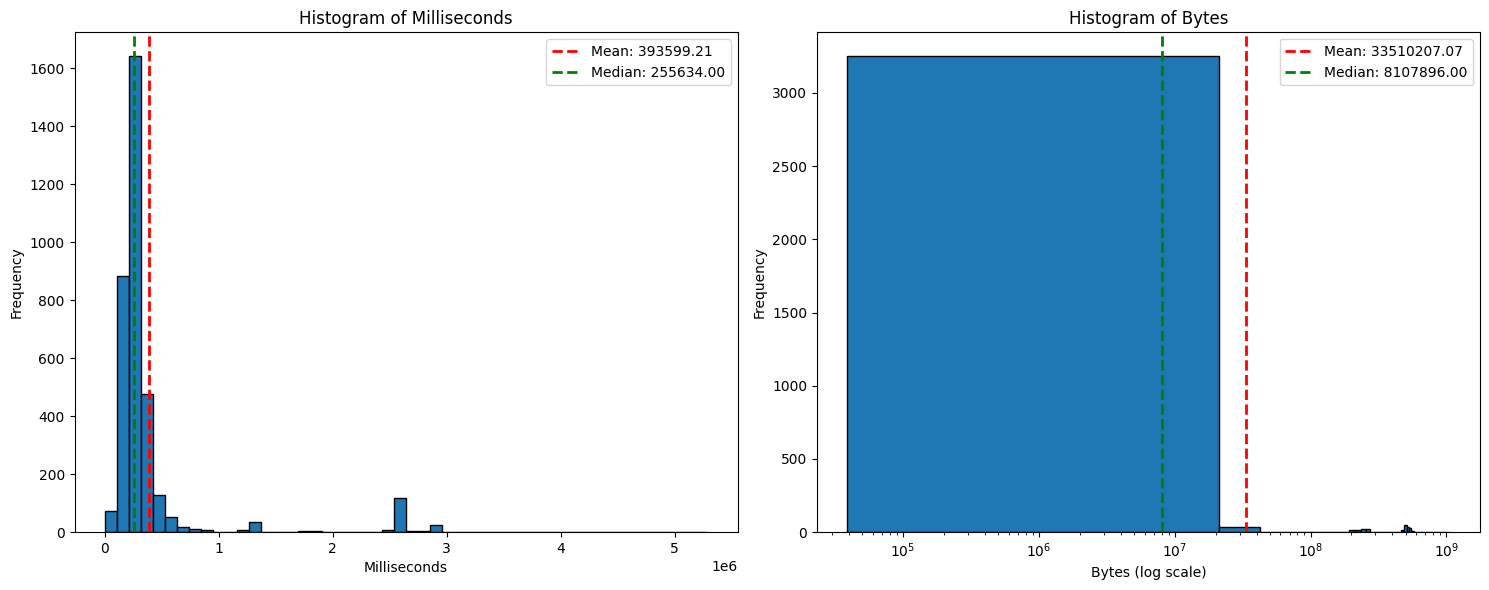

In [44]:
# First I Draw Histogram For These Two Columns
plot_histograms(df, ['Milliseconds', 'Bytes'])

Based on the histogram, the method that uses z-score is not appropriate because the 'Milliseconds' and 'Bytes' are not even roughly normal.

In [45]:
z_score_outliers = z_score_outliers_fun(track_df,numeric_features,3)
z_score_outliers

{'Milliseconds': Series([], Name: TrackId, dtype: int64),
 'Bytes': Series([], Name: TrackId, dtype: int64)}

Interquartile Range (IQR) method would be appropriate. It's resistant to extreme outliers and doesn't assume a normal distribution.</br> Since Boxplot using IQR the result of boxplot will be the same.

In [46]:
iqr_outliers = iqr_outliers_fun(track_df,numeric_features)
millisecods_outliers = iqr_outliers['Milliseconds']
bytes_outliers = iqr_outliers['Bytes']
# As The Results Shows Around 10% Of Each Column Is Outlier, Which Makes Us To Investigate More. 
# Using More Advanced Method, 
# Like Isolation Forest Could Help Us To Get The Better Understanding Of Outliers.


Outliers in Milliseconds:
Number of outliers: 357
Percentage of outliers: 10.19%
Range for non-outliers: 35735.00 to 493191.00

Outliers in Bytes:
Number of outliers: 343
Percentage of outliers: 9.79%
Range for non-outliers: 456230.75 to 16153124.75


Isolation Forest Method can handle the skewed distribution like 'Milliseconds' and It's effective for the wide range of values like 'Bytes'. </br>The Isolation Forest algorithm is particularly effective for detecting outliers in data that do not follow a normal distribution.

In [47]:
# Contamination Is The Expected Percentage Of Outliers
outliers = isolation_forest_outliers(df,numeric_features,contamination=0.05)


Outliers in Milliseconds:
Number of outliers: 175
Percentage of outliers: 5.00%

Outliers in Bytes:
Number of outliers: 176
Percentage of outliers: 5.02%


In [48]:
is_milli_out = outliers['Milliseconds']
is_bytes_out = outliers['Bytes']

In [49]:
milli_intersection = outliers_intersection(is_milli_out,millisecods_outliers)
bytes_outliers = outliers_intersection(is_bytes_out,bytes_outliers)

The Number Of Common Outliers Between These Two Lists is: 162 
The Number Of Common Outliers Between These Two Lists is: 176 



Using these two approaches, I identified that 162 records could be considered outliers for 'Milliseconds' and 176 records could be considered outliers for 'Bytes'. However, I prefer to keep these records since, in the real world, there are many music tracks that are very long and require more space to be saved.

# Top Three Genres And Their Distribution

I Have Created inv_line_custom DataFrame Which Has A Total_Sale For Each Track In Each Invoice.
Then I've Merged This DataFrame With track_df_custom DataFrame, Which Shows How Much A Track Has Been Sold.
Now I Will Use That To Calculate Top Three Genres.


,TrackId,Genre,MediaType,Composer,UnitPrice,Total_Sale
0,1,Rock,MPEG audio file,"Angus Young, Malcolm Young, Brian Johnson",0.99,0.99
1,2,Rock,Protected AAC audio file,"U. Dirkschneider, W. Hoffmann, H. Frank, P. Ba...",0.99,1.98
2,3,Rock,Protected AAC audio file,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Ho...",0.99,0.99
3,4,Rock,Protected AAC audio file,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. D...",0.99,0.99
4,5,Rock,Protected AAC audio file,Deaffy & R.A. Smith-Diesel,0.99,0.99
...,...,...,...,...,...,...
3498,3499,Classical,Protected AAC audio file,None,0.99,0.99
3499,3500,Classical,Protected AAC audio file,Franz Schubert,0.99,1.98
3500,3501,Classical,Protected AAC audio file,Claudio Monteverdi,0.99,0.00
3501,3502,Classical,Protected AAC audio file,Wolfgang Amadeus Mozart,0.99,0.00


In [50]:
top_three_genres = track_df_custom.groupby('Genre')['Total_Sale']\
.sum().reset_index().sort_values(ascending=False, by='Total_Sale').head(3)
top_three_genres

,Genre,Total_Sale
18,Rock,826.65
12,Latin,382.14
13,Metal,261.36


In [59]:
top_genres_list = top_three_genres['Genre'].tolist()
filtered_df = track_df_custom[track_df_custom['Genre'].isin(top_genres_list)]
summary_stats = filtered_df.groupby('Genre')['Total_Sale'].describe().reset_index()
summary_stats

,Genre,count,mean,std,min,25%,50%,75%,max
0,Latin,579.0,0.660000,0.611702,0.0,0.0,0.99,0.99,1.98
1,Metal,374.0,0.698824,0.614369,0.0,0.0,0.99,0.99,1.98
2,Rock,1297.0,0.637355,0.600881,0.0,0.0,0.99,0.99,1.98


In [67]:
filtered_top_three = track_df_custom.loc[track_df_custom['Genre'].isin(top_genres_list),\
                                         ['TrackId','Genre','Total_Sale']]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

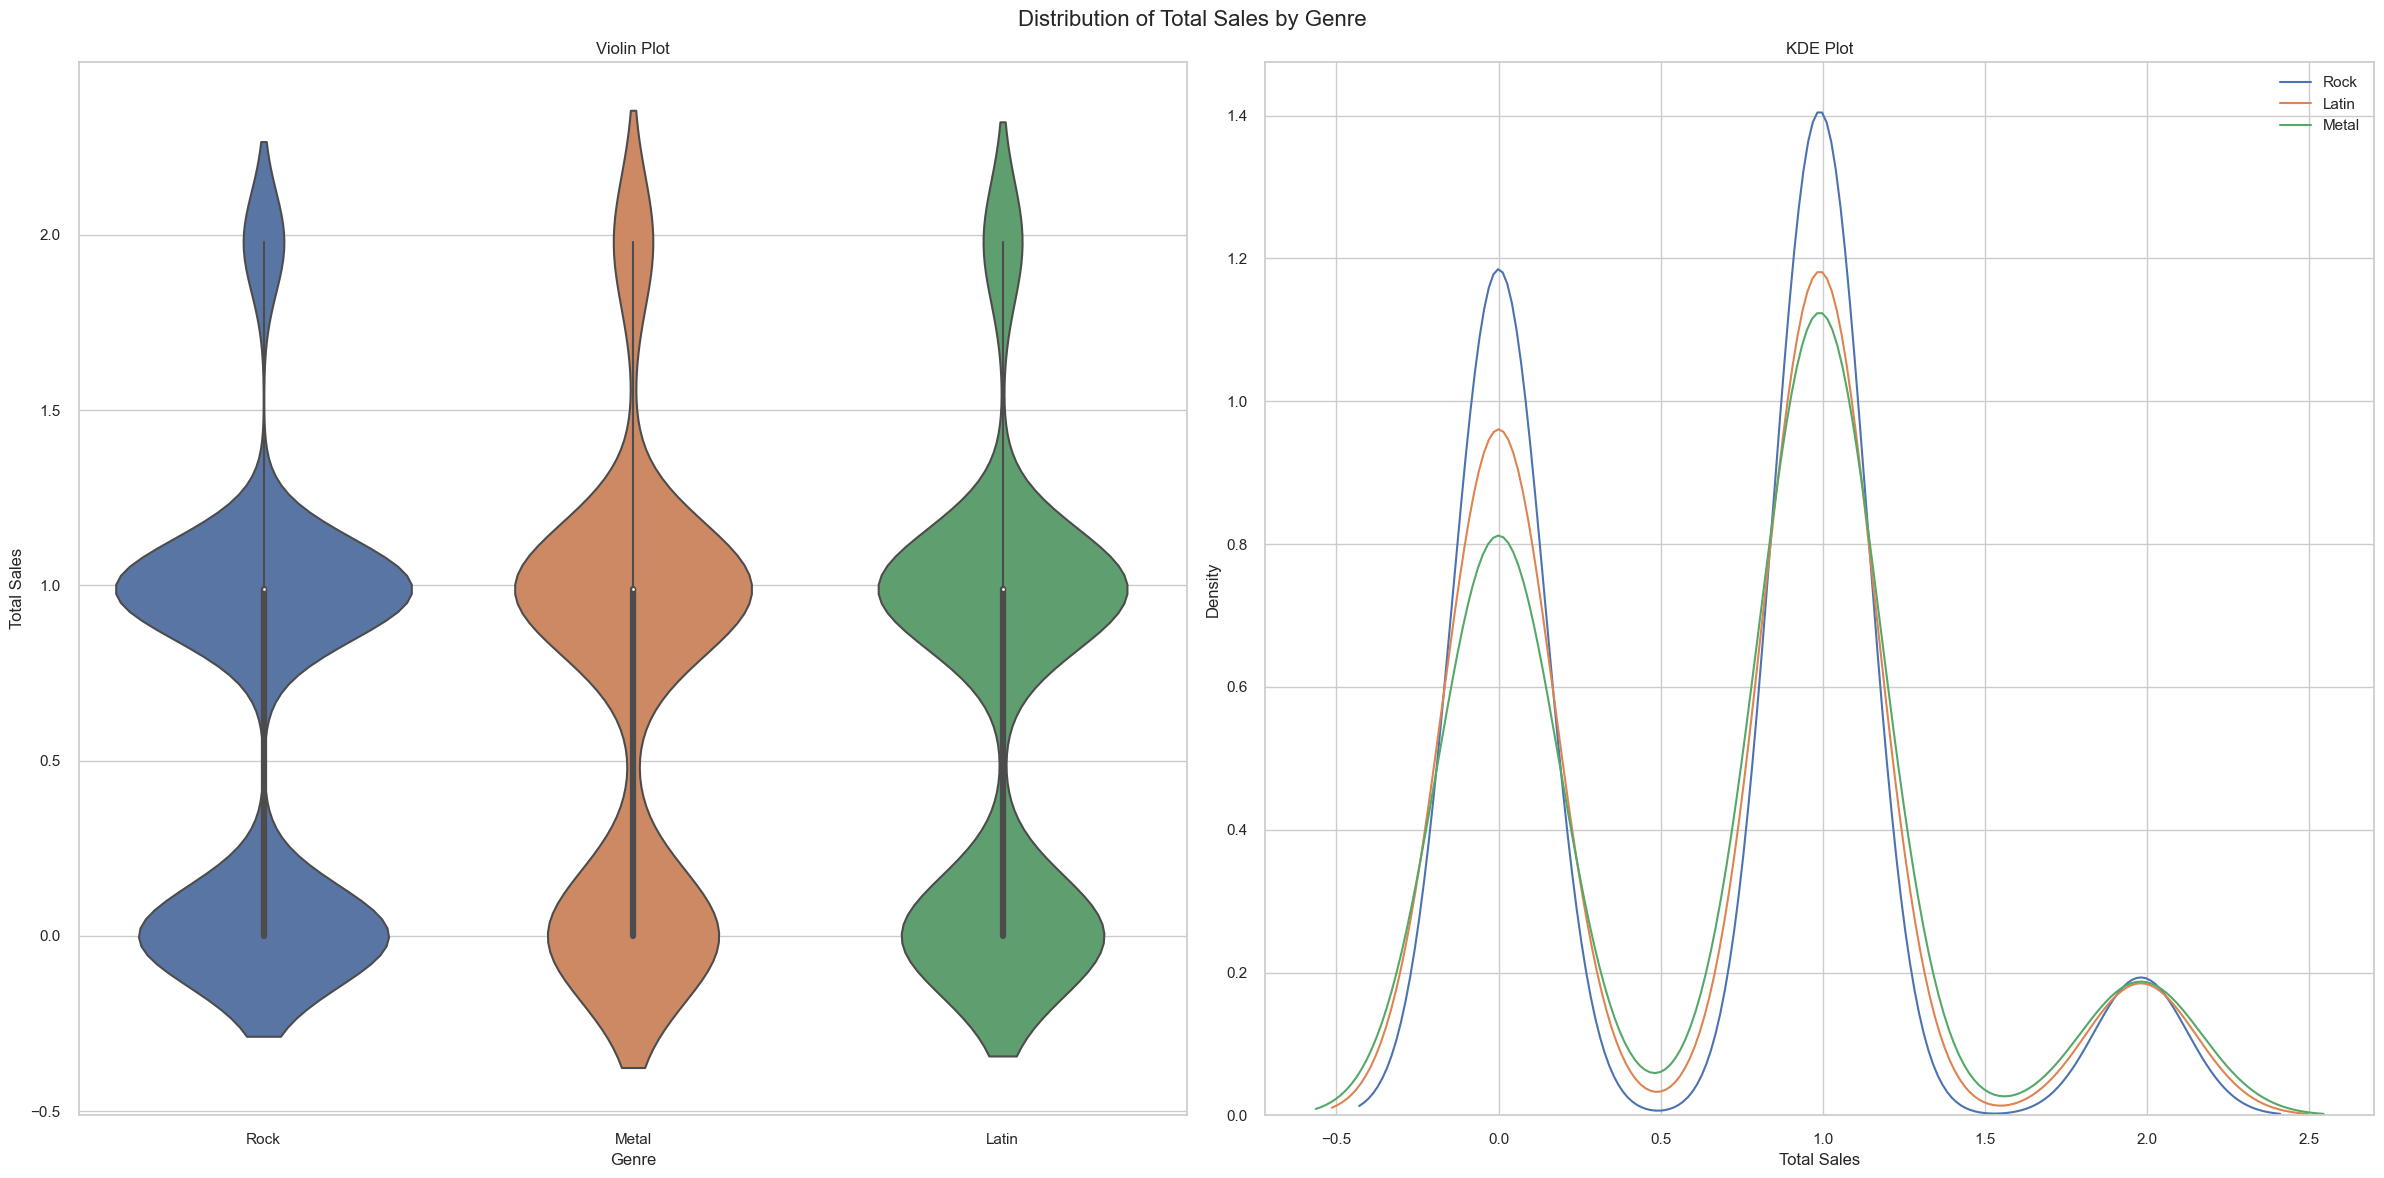

In [80]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(24, 12))
fig.suptitle('Distribution of Total Sales by Genre', fontsize=16)

# Violin Plot
sns.violinplot(x='Genre', y='Total_Sale', data=filtered_top_three, ax=axes[0])
axes[0].set_title('Violin Plot')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Total Sales')

# KDE Plot
for genre in top_genres_list:
    sns.kdeplot(filtered_top_three[filtered_top_three['Genre'] == genre]['Total_Sale'],\
                ax=axes[1], label=genre)
axes[1].set_title('KDE Plot')
axes[1].set_xlabel('Total Sales')
axes[1].set_ylabel('Density')
axes[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

# Relationship between length of track and its price

We can use different methods to achive our goal. Here I will mention some of them.

Null-Hypothesis: There is no relationship between 'Milliseconds' and 'UnitPrice'

In [81]:
# Correlation
correlation = track_df['Milliseconds'].corr(track_df['UnitPrice'])
print(f"Pearson correlation coefficient: {correlation}")
# The Result Shows There Is A Strong Correlation Between Them

Pearson correlation coefficient: 0.9317964749112746


In [82]:
# Linear Regression
slope, intercept, r_value, p_value, std_err = linregress(track_df['Milliseconds'], track_df['UnitPrice'])
print(f"R-squared: {r_value**2}")
print(f"Slope: {slope}")
print(f"P-value: {p_value}")

R-squared: 0.8682446706570778
Slope: 4.162674764444724e-07
P-value: 0.0


<ol>
    <li>R-squared: 0.8682446706570778
This value indicates that approximately 86.82% of the variance in UnitPrice can be explained by Milliseconds. This is a strong relationship, suggesting that the duration of a track (in milliseconds) is a good predictor of its price.</li></br>
<li>Slope: 4.162674764444724e-07
This positive slope indicates that as Milliseconds increase, UnitPrice tends to increase as well. Specifically, for every 1 millisecond increase in track length.</li></br>
<li>P-value: 0.0
A p-value of 0.0 (or very close to 0) indicates that the relationship between Milliseconds and UnitPrice is statistically significant.</li>
</ol>

In [83]:
# T-Test
t_statistic, t_p_value = ttest_ind(track_df['Milliseconds'], track_df['UnitPrice'])
print(f"T-test p-value: {t_p_value}")

T-test p-value: 0.0


There is a statistically significant difference between the means of the 'Milliseconds' and 'UnitPrice' columns.</br></br>
After considering the results of all these methods, we can say there is a strong relationship between 'Milliseconds' and 'UnitPrice'. Therefore, we can reject the null hypothesis that these two variables are independent.

# Retionship Between Genre And MediaType

Null-Hypothesis: There is no relationship between 'Genre' and 'MediaTpe'

In [84]:
contingency_table = pd.crosstab(track_df_custom['Genre'], track_df_custom['MediaType'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")

Chi-square statistic: 5650.180437321978
p-value: 0.0


Chi-square Test:
<ul>
    <li>Chi-square statistic: 5650.18</li>
    <li>p-value: 0.0 (effectively zero)</li>
</ul></br>
The extremely low p-value (< 0.05) indicates that there is a statistically significant relationship between Genre and MediaType. We can reject the null hypothesis that these variables are independent.

<IPython.core.display.Javascript object>

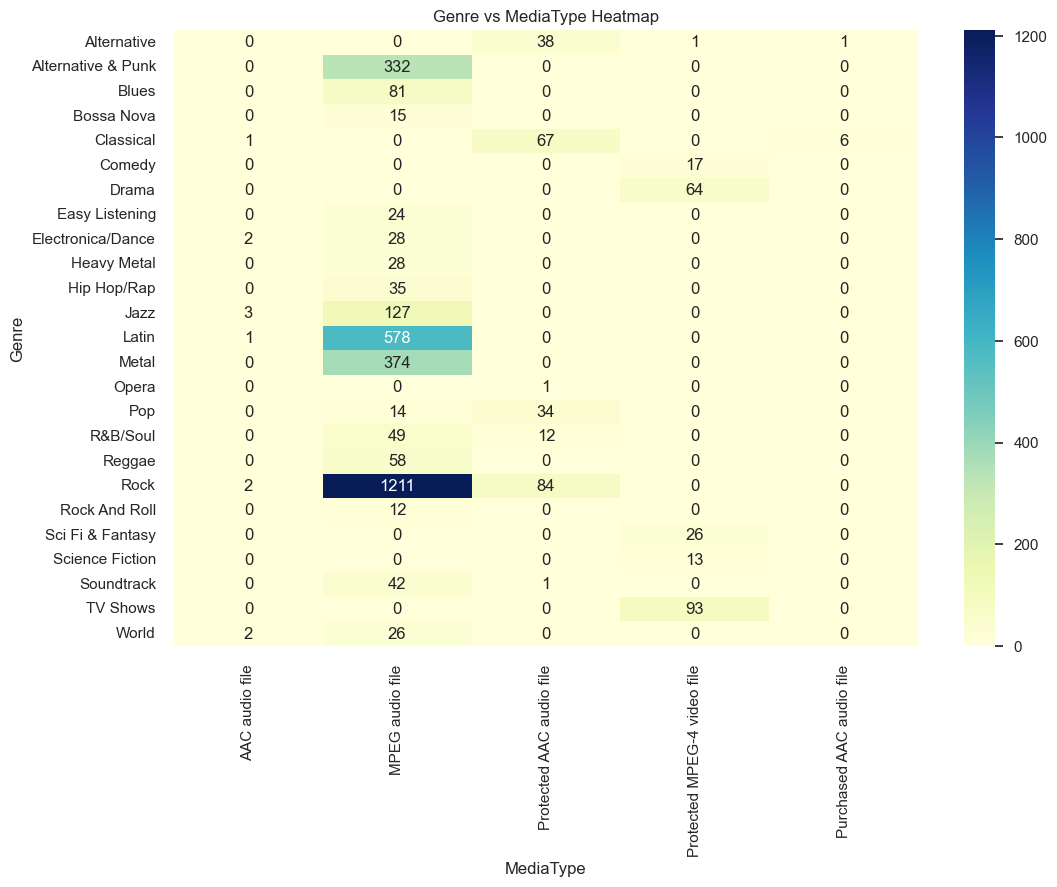

In [85]:
# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Genre vs MediaType Heatmap')
plt.show()

<ul>
    <li>The heatmap clearly shows that MPEG audio files are the most common media type across almost all genres.</li>
    <li>Rock has the highest number of tracks (1211) in MPEG audio format.</li>
    <li>Latin and Metal also have significant numbers of MPEG audio tracks (578 and 374 respectively).</li>
    <li>Protected AAC audio files are the second most common, but they're concentrated in fewer genres (mainly Alternative, Classical, and Rock).</li>
    <li>Video files (Protected MPEG-4) are rare and appear only in specific genres like TV Shows, Sci Fi & Fantasy, and Comedy.</li>
</ul>
</br>
<header>Conclusion: </header>
Certain genres show clear preferences for specific media types. For example:
<ul>
<li>Rock, Latin, and Metal heavily favor MPEG audio files.</li>
<li>Classical music has a notable presence in Protected AAC format.</li>
<li>TV Shows, Sci Fi & Fantasy, and Comedy are the main genres using video formats.</li>
</ul>

    

In [86]:
mi = mutual_info_score(track_df_custom['Genre'], track_df_custom['MediaType'])
print(f"Mutual Information: {mi}")

Mutual Information: 0.37627197439298254


A score of 0.3763 suggests a moderate level of mutual dependence between Genre and MediaType.

# Confidence Interval

In [87]:
# Mean Of Milliseconds By Genre
milliseconds_mean_by_Genre = track_df.groupby('GenreId')['Milliseconds'].mean().reset_index()
milliseconds_mean_by_Genre.head(10)

,GenreId,Milliseconds
0,1,283910.043177
1,2,291755.376923
2,3,309749.443850
3,4,234353.849398
4,5,134643.500000
5,6,270359.777778
6,7,232859.262522
7,8,247177.758621
8,9,229034.104167
9,10,244370.883721


In [92]:
conf_intv_95 = {}
for id in track_df['GenreId'].unique():
    filtered_by_genre = track_df.loc[track_df['GenreId'].eq(id),'Milliseconds']
    mean, interval = calculate_confidence_interval(filtered_by_genre)
    conf_intv_95[f'{id}'] = [mean, interval]

In [93]:
categories = list(conf_intv_95.keys())
means = [conf_intv_95[cat][0] for cat in categories]
lower_bounds = [conf_intv_95[cat][1][0] for cat in categories]
upper_bounds = [conf_intv_95[cat][1][1] for cat in categories]

# Calculate error bars
errors = [((upper - lower) / 2 if not np.isnan(lower) else 0) for lower, upper in zip(lower_bounds, upper_bounds)]

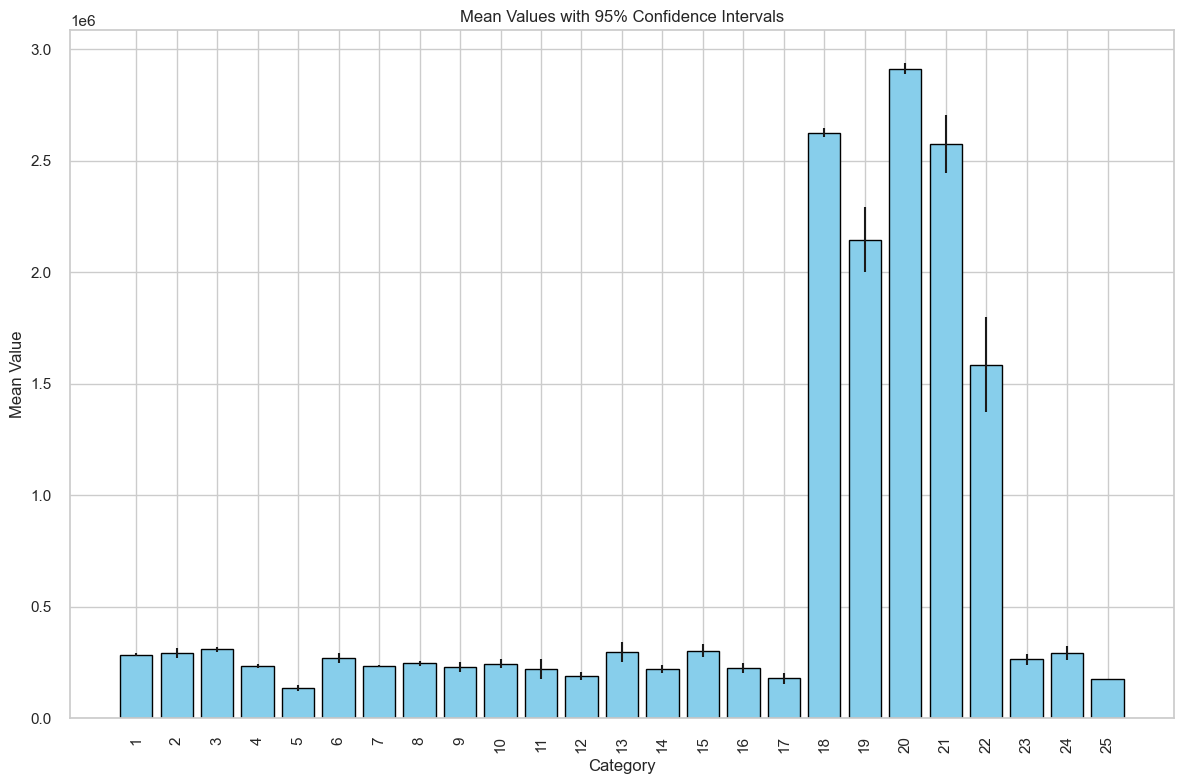

In [94]:
plt.figure(figsize=(12, 8))
plt.bar(categories, means, yerr=errors, capsize=5, color='skyblue', edgecolor='black')
plt.xlabel('Category')
plt.ylabel('Mean Value')
plt.title('Mean Values with 95% Confidence Intervals')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

Null-Hypothesis: The mean of 'Milliseconds' and 'Genre' are independent.

In [95]:
categorical_numeric_correlations(milliseconds_mean_by_Genre,['GenreId'],'Milliseconds')

{'GenreId': {'chi2': 75.00000000000001,
  'chi2_p_value': 0.38132140023088335,
  'mutual_information': 0.2369857882578974,
  'rf_importance': 1.0}}

Chi-square test:
<ol>
    <li>The p-value (0.3813) is greater than the common significance levels (0.05 or 0.01). This suggests that we fail to reject the null hypothesis of independence between 'GenreId' and the 'Milliseconds_Mean'.</li>
<li>In other words, there isn't strong statistical evidence of a significant relationship between 'GenreId' and the 'Milliseconds_Mean' based on this test.</li>
</ol>

Mutual Information:
<ol>
<li>The mutual information score of 0.2156 indicates the amount of information shared between 'GenreId' and 'Milliseconds_Mean'.</li>
<li>A score of 0.2156 suggests a moderate level of mutual dependence, indicating that knowing the 'GenreId' provides some information about 'Milliseconds_Mean', and vice versa.</li>
<ol>    

Random Forest Importance:
<ol>
<li>The importance score of 1.0 from a Random Forest model suggests that 'GenreId' is considered a very important feature in predicting the target variable.</li>
</ol>

The discrepancy between these results suggests that while there might not be a simple linear relationship (as indicated by the chi-square test), there could be more complex or non-linear relationships that are captured by the mutual information and Random Forest approaches.

In [96]:
# Country And Total Mean
BillingCountry_Total_mean = invoice_df.groupby('BillingCountry')['Total'].mean().reset_index().\
sort_values(ascending=False, by='Total')
BillingCountry_Total_mean.head(10)

,BillingCountry,Total
6,Chile,6.660000
12,Hungary,6.517143
14,Ireland,6.517143
7,Czech Republic,6.445714
2,Austria,6.088571
9,Finland,5.945714
16,Netherlands,5.802857
13,India,5.789231
22,USA,5.747912
17,Norway,5.660000


In [97]:
countries_conf_intv_95 = {}
for country in invoice_df['BillingCountry'].unique():
    filtered_by_country = invoice_df.loc[invoice_df['BillingCountry'].eq(country),'Total']
    mean, interval = calculate_confidence_interval(filtered_by_country)
    countries_conf_intv_95[f'{country}'] = [mean, interval]

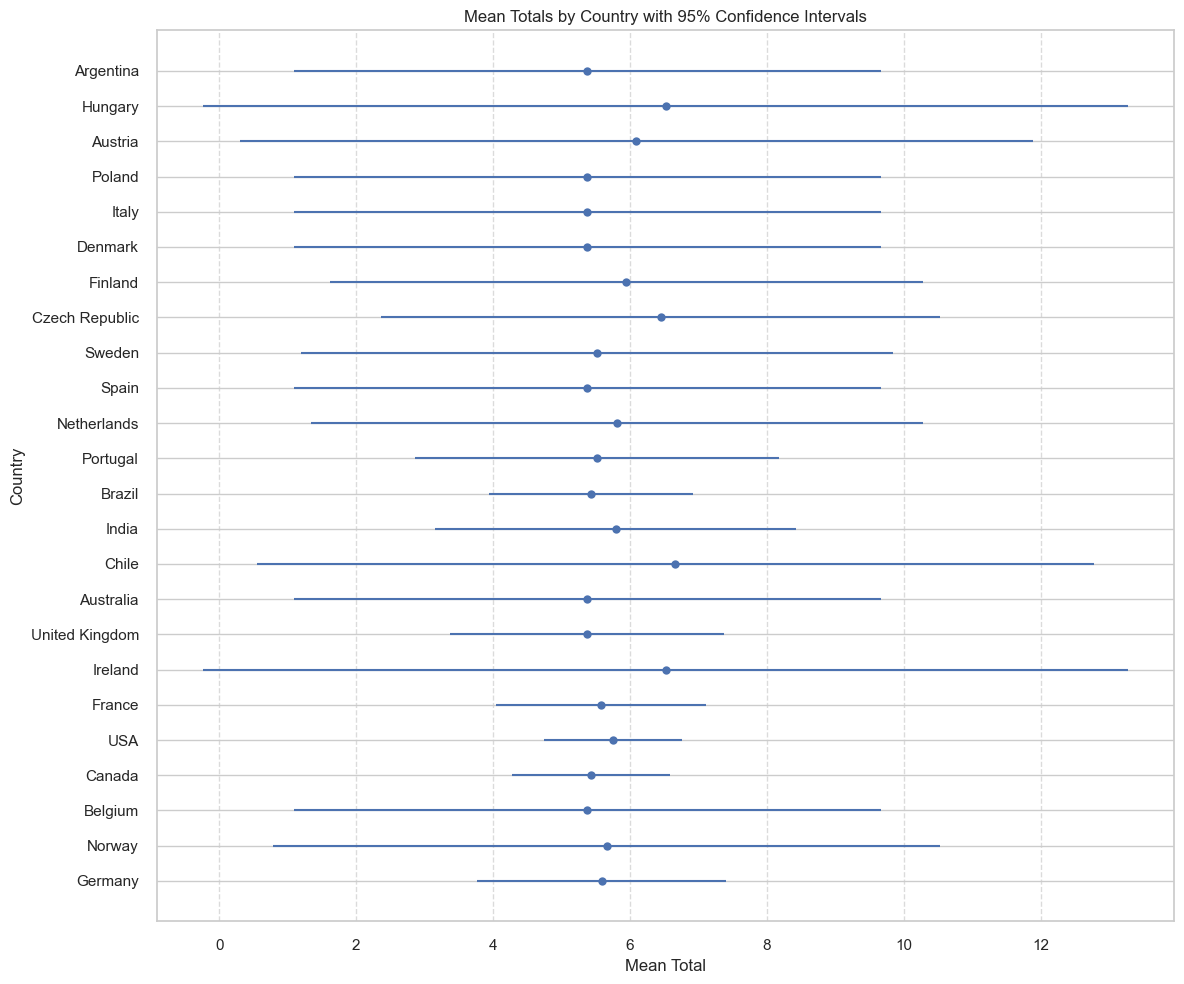

In [98]:
countries = list(countries_conf_intv_95.keys())
means = [countries_conf_intv_95[country][0] for country in countries]
lowers = [countries_conf_intv_95[country][1][0] for country in countries]
uppers = [countries_conf_intv_95[country][1][1] for country in countries]

# Calculating Error Bar 
yerr = np.array([
    [mean - low for mean, low in zip(means, lowers)],  # Distance from mean to lower bound
    [high - mean for mean, high in zip(means, uppers)]  # Distance from mean to upper bound
])

fig, ax = plt.subplots(figsize=(12, 10))
ax.errorbar(means, countries, xerr=yerr, fmt='o', capsize=5)

ax.set_xlabel('Mean Total')
ax.set_ylabel('Country')
ax.set_title('Mean Totals by Country with 95% Confidence Intervals')
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [99]:
# Customer And Number Of Tracks Sold
customer_inv_line = pd.merge(invoiceline_df, invoice_df, on='InvoiceId', how= 'left', suffixes=['_line', '_invo'])
customer_inv_line.head()

,InvoiceLineId,InvoiceId,TrackId,UnitPrice,Quantity,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,1,1,2,0.99,1,2,2021-01-01,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98
1,2,1,4,0.99,1,2,2021-01-01,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98
2,3,2,6,0.99,1,4,2021-01-02,Ullevålsveien 14,Oslo,None,Norway,0171,3.96
3,4,2,8,0.99,1,4,2021-01-02,Ullevålsveien 14,Oslo,None,Norway,0171,3.96
4,5,2,10,0.99,1,4,2021-01-02,Ullevålsveien 14,Oslo,None,Norway,0171,3.96


In [100]:
customer_count_tracks = customer_inv_line.groupby('CustomerId')['TrackId'].count().reset_index(name='TrackCount')
customer_count_invoice = customer_inv_line.groupby('CustomerId')['InvoiceId'].nunique().\
reset_index(name='InvoiceCount')

In [103]:
mean = customer_count_tracks['TrackCount'] / customer_count_invoice['InvoiceCount']
customer_mean_track = pd.DataFrame({'CustomerId':customer_count_tracks['CustomerId'], 
                                    'Mean_Purchased_Track': mean })


array([7, 6], dtype=int64)